#  Import the dependencies, construct the tool functions

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file

import numpy as np
import matplotlib.pyplot as plt
import random

TEST_SIZE=0.33
# 读入数据
def get_data_numpyArray(file_path):
    data = load_svmlight_file(file_path)
    return data[0].toarray(), data[1]


#将具有-1和1的标签数组转化为0和1的标签数组
def transform_ylable_from_posNe1_to_01(ylables):
    return np.array([int(y_item/2 + 0.5) for y_item in ylables])

#给数据集加一列1
def add_X_bColumn(X):
   b_train = np.ones(X.shape[0])
   return np.c_[X, b_train]

def shuffle(X_train,y_train):
    for i in reversed(range(1, len(X_train))):
        j = random.randint(0,i)
        swap_x = X_train[i].copy()
        X_train[i] = X_train[j]
        X_train[j] = swap_x
        swap_y = y_train[i].copy()
        y_train[i] = y_train[j]
        y_train[j] = swap_y
        
        


#  Define functions to take derivatives and calculate losses

In [3]:
#计算损失
def compute_lost(X,y,W,reg):
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    # 对于每一个样本，累加loss
    for i in range(num_train):
        #计算出x下标i的类别向量
        scores = X[i].dot(W)     # (1, C)
        #得到x下标i正确的类别向量，y[i]代表x下标i个数据是第y[i]个类
        #y[i]属于[0....类别的个数C]
        correct_class_score = scores[int(y[i])]
        #遍历每个类别，计算lost
        for j in range(num_classes):
            if j == y[i]:
                continue
            # 根据 SVM 损失函数计算
            margin = scores[j] - correct_class_score + 1    # note delta = 1
            # 当 margin>0 时，才会有损失，此时也会有梯度的累加
            if margin > 0:      # max(0, yi - yc + 1)
                loss += margin
    # 训练数据平均损失
    loss /= num_train
    # 正则损失
    loss += reg * np.sum(W * W)
    return loss

#计算梯度
def svm_gradient(W, X, y, reg):
    dW = np.zeros(W.shape)    # initialize the gradient as zero
    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    for i in range(num_train):
        #计算出x下标i的类别向量
        scores = X[i].dot(W)     # (1, C)
        #得到x下标i正确的类别向量，y[i]代表x下标i个数据是第y[i]个类
        #y[i]属于[0....类别的个数C]
        correct_class_score = scores[int(y[i])]
        #遍历每个类别，计算lost
        for j in range(num_classes):
            if j == y[i]:
                continue
            # 根据 SVM 损失函数计算
            margin = scores[j] - correct_class_score + 1    # note delta = 1
            # 当 margin>0 时，才会有损失，此时也会有梯度的累加
            if margin > 0:      # max(0, yi - yc + 1)
                 # 根据公式：∇Wyi Li = - xiT(∑j≠yi1(xiWj - xiWyi +1>0)) + 2λWyi
                 #虽然严格按照矩阵来讲列向量和行向量不能相加
                 #但是这里抽取某一行或者某一列，都是一纬的，可以进行
                dW[:, y[i]] += -X[i, :]   # y[i] 是正确的类
                #  根据公式： ∇Wj Li = xiT 1(xiWj - xiWyi +1>0) + 2λWj ,
                dW[:, j] += X[i, :]
    # 训练数据平均损失
    dW /= num_train
    #加上正则的偏导
    dW += 2 * reg * W
    return dW

#  Construct the optimization function 

In [4]:
def NAG(vs,dW,alpha, gamma=.9):
    vs = dW * alpha + vs * gamma
    return vs

def RMSProp(dW, G, alpha,gramma):
    eps_stable = 1e-7
    G = gramma * G + dW**2 *(1 -gramma)
    G_sq = (G + eps_stable)**0.5
    return  dW * alpha / G_sq    

def AdaDelta(dW, G, t,gramma):
    eps_stable = 1e-7
    G = gramma * G + dW**2 *(1 -gramma)
    G_sq = (G + eps_stable)**0.5
    t_sq = (t + eps_stable)**0.5
    delta_theta_t = dW * t_sq / G_sq 
    t = gramma * t + delta_theta_t**2 *(1 -gramma)  
    return delta_theta_t

def Adam(dW, G, m,belta,gramma,nga):
    eps_stable = 1e-7
    m = belta * m + dW *(1 -belta)
    G = gramma * G + dW**2 *(1 -gramma)
    alpha = nga * ((1- gramma)**0.5)/(1 - belta )
    G_sq = (G + eps_stable)**0.5
    return alpha * m / G_sq

# Construct the stochastic gradient descent function,adding optimization function

In [5]:
def classify_f_stochastic(X_train,y_train,X_test,y_test,W,numiter,eta,reg,batch_size):
    iterations=[]
    lost_y_train = []
    shuffle(X_train,y_train)
    k = 0
    m = X_train.shape[0]
    for i in range(1,numiter+1):
        if(k + batch_size > m):
            shuffle(X_train,y_train)
            k = 0
        X_train_batch = X_train[k:k+batch_size]
        y_train_batch = y_train[k:k+batch_size]
        k = k + batch_size
        grad = svm_gradient(W,X_train_batch,y_train_batch,reg)
        W -= eta * grad  
        lost_train = compute_lost(X_train,y_train,W,reg)
        iterations.append(i)
        lost_y_train.append(lost_train)
    return iterations,lost_y_train

def classify_f_stochastic_NAG(X_train,y_train,X_test,y_test,W,numiter,eta,reg,batch_size):
    iterations=[]
    lost_y_train = []
    shuffle(X_train,y_train)
    k = 0
    m = X_train.shape[0]
    vs = np.zeros(W.shape)
    for i in range(1,numiter+1):
        if(k + batch_size > m):
            shuffle(X_train,y_train)
            k = 0
        X_train_batch = X_train[k:k+batch_size]
        y_train_batch = y_train[k:k+batch_size]
        k = k + batch_size
        grad = svm_gradient(W,X_train_batch,y_train_batch,reg)
        W -= NAG(vs,grad,eta)  
        lost_train = compute_lost(X_train,y_train,W,reg)
        iterations.append(i)
        lost_y_train.append(lost_train)
    return iterations,lost_y_train

def classify_f_stochastic_RMSProp(X_train,y_train,X_test,y_test,W,numiter,eta,gamma,reg,batch_size):
    iterations=[]
    lost_y_train = []
    shuffle(X_train,y_train)
    k = 0
    m = X_train.shape[0]
    G = np.zeros(W.shape)
    for i in range(1,numiter+1):
        if(k + batch_size > m):
            shuffle(X_train,y_train)
            k = 0
        X_train_batch = X_train[k:k+batch_size]
        y_train_batch = y_train[k:k+batch_size]
        k = k + batch_size
        grad = svm_gradient(W,X_train_batch,y_train_batch,reg)
        W -= RMSProp(grad,G,eta,gamma)  
        lost_train = compute_lost(X_train,y_train,W,reg)
        iterations.append(i)
        lost_y_train.append(lost_train)
    return iterations,lost_y_train

def classify_f_stochastic_AdaDelta(X_train,y_train,X_test,y_test,W,numiter,gamma,reg,batch_size):
    iterations=[]
    lost_y_train = []
    shuffle(X_train,y_train)
    k = 0
    m = X_train.shape[0]
    G = np.zeros(W.shape)
    t = np.zeros(W.shape)
    for i in range(1,numiter+1):
        if(k + batch_size > m):
            shuffle(X_train,y_train)
            k = 0
        X_train_batch = X_train[k:k+batch_size]
        y_train_batch = y_train[k:k+batch_size]
        k = k + batch_size
        grad = svm_gradient(W,X_train_batch,y_train_batch,reg)
        W -= AdaDelta(grad,G,t,gamma)
        lost_train = compute_lost(X_train,y_train,W,reg)
        iterations.append(i)
        lost_y_train.append(lost_train)
    return iterations,lost_y_train

def classify_f_stochastic_Adam(X_train,y_train,X_test,y_test,W,numiter,beta,gamma,eta,reg,batch_size):
    iterations=[]
    lost_y_train = []
    shuffle(X_train,y_train)
    k = 0
    m = X_train.shape[0]
    G = np.zeros(W.shape)
    mt = np.zeros(W.shape)
    for i in range(1,numiter+1):
        if(k + batch_size > m):
            shuffle(X_train,y_train)
            k = 0
        X_train_batch = X_train[k:k+batch_size]
        y_train_batch = y_train[k:k+batch_size]
        k = k + batch_size
        grad = svm_gradient(W,X_train_batch,y_train_batch,reg)
        W -= Adam(grad,G,mt,beta,gamma,eta)
        lost_train = compute_lost(X_train,y_train,W,reg)
        iterations.append(i)
        lost_y_train.append(lost_train)
    return iterations,lost_y_train

# Data pre-processing

In [6]:
X, y = get_data_numpyArray("a9a.txt")
X = add_X_bColumn(X)
y = transform_ylable_from_posNe1_to_01(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33)
#对权重进行初始化
W = np.random.randn(X_train.shape[1], 2) * 0.01

# Comparison of the eta of stochastic gradient descent

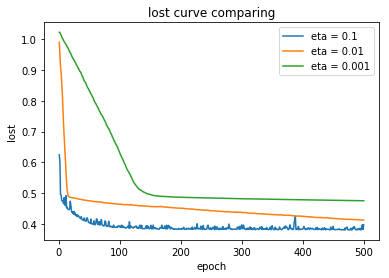

In [7]:
plt.figure(1)
plt.xlabel('epoch')
plt.ylabel('lost')
plt.title('lost curve comparing')
iterations,lost_y_train_normal_1= classify_f_stochastic(X_train,y_train,X_test,y_test,W.copy(),500,0.1,0.01,64)
iterations,lost_y_train_normal_2= classify_f_stochastic(X_train,y_train,X_test,y_test,W.copy(),500,0.01,0.01,64)
iterations,lost_y_train_normal_3= classify_f_stochastic(X_train,y_train,X_test,y_test,W.copy(),500,0.001,0.01,64)
plt.plot(iterations, lost_y_train_normal_1,label='eta = 0.1')
plt.plot(iterations, lost_y_train_normal_2, label='eta = 0.01')
plt.plot(iterations, lost_y_train_normal_3,label='eta = 0.001')
plt.legend()
plt.show()

# Comparison of the eta of NAG

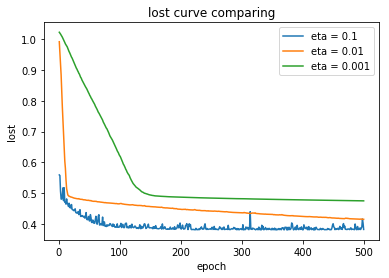

In [8]:
plt.figure(2)
plt.xlabel('epoch')
plt.ylabel('lost')
plt.title('lost curve comparing')
iterations,lost_y_train_NAG_1 = classify_f_stochastic_NAG(X_train,y_train,X_test,y_test,W.copy(),500,0.1,0.01,64)
iterations,lost_y_train_NAG_2 = classify_f_stochastic_NAG(X_train,y_train,X_test,y_test,W.copy(),500,0.01,0.01,64)
iterations,lost_y_train_NAG_3 = classify_f_stochastic_NAG(X_train,y_train,X_test,y_test,W.copy(),500,0.001,0.01,64)
plt.plot(iterations, lost_y_train_NAG_1,label='eta = 0.1')
plt.plot(iterations, lost_y_train_NAG_2, label='eta = 0.01')
plt.plot(iterations, lost_y_train_NAG_3,label='eta = 0.001')
plt.legend()
plt.show()

# Comparison of the eta of RMSProp

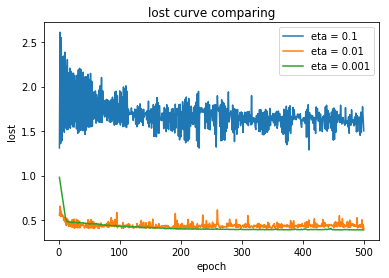

In [9]:
plt.figure(3)
plt.xlabel('epoch')
plt.ylabel('lost')
plt.title('lost curve comparing')
iterations,lost_y_train_1 =  classify_f_stochastic_RMSProp(X_train,y_train,X_test,y_test,W.copy(),500,0.1,0.9,0.01,64)
iterations,lost_y_train_2 =  classify_f_stochastic_RMSProp(X_train,y_train,X_test,y_test,W.copy(),500,0.01,0.9,0.01,64)
iterations,lost_y_train_3 =  classify_f_stochastic_RMSProp(X_train,y_train,X_test,y_test,W.copy(),500,0.001,0.9,0.01,64)
plt.plot(iterations, lost_y_train_1,label='eta = 0.1')
plt.plot(iterations, lost_y_train_2, label='eta = 0.01')
plt.plot(iterations, lost_y_train_3, label='eta = 0.001')
plt.legend()
plt.show()

# Comparison of the eta of Adam

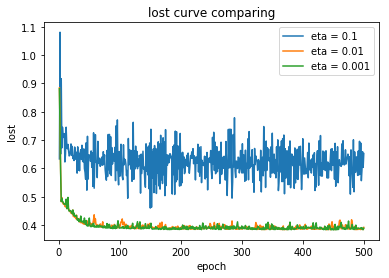

In [10]:
plt.figure(4)
plt.xlabel('epoch')
plt.ylabel('lost')
plt.title('lost curve comparing')
iterations,lost_y_train_1 =  classify_f_stochastic_Adam(X_train,y_train,X_test,y_test,W.copy(),500,0.9,0.999,0.1,0.01,64)
iterations,lost_y_train_2 =  classify_f_stochastic_Adam(X_train,y_train,X_test,y_test,W.copy(),500,0.9,0.999,0.01,0.01,64)
iterations,lost_y_train_3 =  classify_f_stochastic_Adam(X_train,y_train,X_test,y_test,W.copy(),500,0.9,0.999,0.01,0.01,64)
plt.plot(iterations, lost_y_train_1,label='eta = 0.1')
plt.plot(iterations, lost_y_train_2, label='eta = 0.01')
plt.plot(iterations, lost_y_train_3, label='eta = 0.001')
plt.legend()
plt.show()

# Comparison of the eta of all

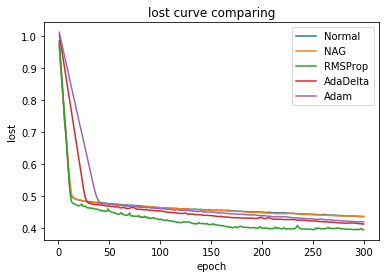

In [11]:
plt.figure(5)
plt.xlabel('epoch')
plt.ylabel('lost')
plt.title('lost curve comparing')
iterations,lost_y_train_normal= classify_f_stochastic(X_train,y_train,X_test,y_test,W.copy(),300,0.01,0.01,64)
iterations,lost_y_train_NAG= classify_f_stochastic_NAG(X_train,y_train,X_test,y_test,W.copy(),300,0.01,0.01,64)
iterations,lost_y_train_RMSProp= classify_f_stochastic_RMSProp(X_train,y_train,X_test,y_test,W.copy(),300,0.001,0.9,0.01,64)
iterations,lost_y_train_AdaDelta= classify_f_stochastic_AdaDelta(X_train,y_train,X_test,y_test,W.copy(),300,0.95,0.01,64)
iterations,lost_y_train_Adam= classify_f_stochastic_Adam(X_train,y_train,X_test,y_test,W.copy(),300,0.9,0.999,0.001,0.01,64)
plt.plot(iterations, lost_y_train_normal,label='Normal')
plt.plot(iterations, lost_y_train_NAG, label='NAG')
plt.plot(iterations, lost_y_train_RMSProp,label='RMSProp')
plt.plot(iterations, lost_y_train_AdaDelta,label='AdaDelta')
plt.plot(iterations, lost_y_train_Adam,label='Adam')
plt.legend()
plt.show()